In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("harunshimanto/epileptic-seizure-recognition")
path = os.path.join(path, "Epileptic Seizure Recognition.csv")
print("Path to dataset files:", path)

# Load data
df = pd.read_csv(path)
print(df.head())
# Drop the 'Unnamed' index column if it exists
df.drop(columns=[col for col in df.columns if "Unnamed" in col], inplace=True)

# Transform target column: seizure=1, non-seizure=0
df['y'] = df['y'].apply(lambda x: 0 if x == 1 else 1)
print(df.head())

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]
    X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X170  X171  X172  \
0  135  190  229  223  192  125   55   -9  -33  -38  ...   -17   -15   -31   
1  386  382  356  331  320  315  307  272  244  232

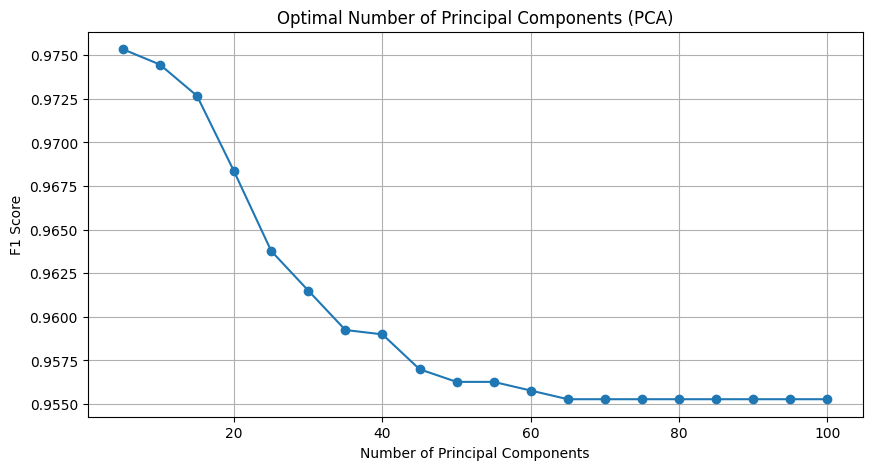

Best number of PCs: 5


In [7]:
# Split features and labels
X = df.drop(columns=['y'])
y = df['y']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find best number of principal components using F1-score
f1_scores = []
components_range = range(5, 105, 5)

for n in components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Plot F1-scores vs number of components
plt.figure(figsize=(10, 5))
plt.plot(components_range, f1_scores, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("F1 Score")
plt.title("Optimal Number of Principal Components (PCA)")
plt.grid()
plt.show()

# Pick best number of components and retrain model
optimal_n = components_range[np.argmax(f1_scores)]
print(f"Best number of PCs: {optimal_n}")


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90       460
           1       0.96      0.99      0.98      1840

    accuracy                           0.96      2300
   macro avg       0.96      0.92      0.94      2300
weighted avg       0.96      0.96      0.96      2300



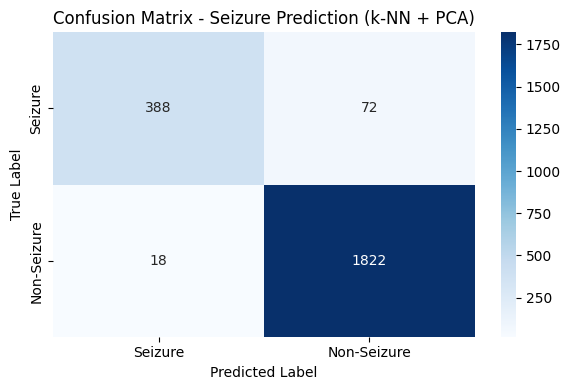

In [8]:
pca = PCA(n_components=optimal_n)
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Visualize the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Seizure", "Non-Seizure"], yticklabels=["Seizure", "Non-Seizure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Seizure Prediction (k-NN + PCA)")
plt.tight_layout()
plt.show()